## 🧭 GOAL:
Train a self-supervised model to forecast E[t+1] from [E[t-n], ..., E[t]], then map the forecasted embedding to a cluster.



## ✅ STEP-BY-STEP OUTLINE

---

### **Step 1: Load Embeddings**

* Load `embeddings.csv` into a NumPy array or pandas DataFrame.
* Confirm shape: `(num_timesteps, embedding_dim)`

---

### **Step 2: Build Sliding Window Dataset**

Create training samples:

* Input: `X[i] = [E[i], E[i+1], ..., E[i+window_size-1]]`
* Target: `y[i] = E[i+window_size]`

This results in:

* `X`: shape `(num_samples, window_size, embedding_dim)`
* `y`: shape `(num_samples, embedding_dim)`

---

### **Step 3: Train/Test Split (Optional)**

* Use 80/20 split (or time-ordered split) for validation.

---

### **Step 4: Define LSTM Model in Keras**

* Use `Sequential` API:

  * LSTM layer → Dense output
* Compile with:

  * Loss: `'mse'`
  * Optimizer: `'adam'`

---

### **Step 5: Train the Model**

```python
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=..., batch_size=...)
```

---

### **Step 6: Predict Next Embedding**

* Pick a time slice (e.g. last 5 embeddings)
* Run `model.predict()` to get `Ê[t+1]`

---

### **Step 7: Assign Cluster to Predicted Embedding**

* Scale `Ê[t+1]` using `StandardScaler` (same one from original clustering)
* Pass into `KNN.predict([Ê_scaled])` to get `Cluster_ID[t+1]`

---

### **Step 8: Evaluate (Optional)**

* Compare predicted cluster with actual `Cluster_ID[t+1]`
* Compute:

  * Accuracy
  * Confusion matrix
  * Embedding prediction error (MSE)


In [1]:
import pandas as pd
import os
from os import path
import json

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    LayerNormalization,
    Lambda,
    Bidirectional,
    Input,
    MultiHeadAttention,
    GlobalAveragePooling1D,
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.losses import MeanSquaredError

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_fscore_support
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from regimetry.config import Config
from regimetry.logger_manager import LoggerManager

In [2]:
logging = LoggerManager.get_logger("unsupervised_next_cluster_prediction")

In [3]:
cfg = Config()
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)
print("EMBEDDINGS DATA:", cfg.EMBEDDINGS_DIR) 
print("REPORTS DATA:", cfg.REPORTS_DIR) 

PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/regimetry
BASE DIR: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed
EMBEDDINGS DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/embeddings
REPORTS DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/reports


In [4]:
embedding_path = path.join(cfg.EMBEDDINGS_DIR, "GBP_USD/ws5/learnable64_default")
cluster_path = path.join(
    cfg.REPORTS_DIR, "GBP_USD/ws5/learnable64/default/nc8", "cluster_assignments.csv"
)

### **Step 1: Load Embeddings**

* Load `embeddings.csv` into a NumPy array or pandas DataFrame.
* Confirm shape: `(num_timesteps, embedding_dim)`

In [5]:
embedding_file = path.join(
    embedding_path,
    "embedding.npy",
)
# 🧾 Load as NumPy array
embeddings = np.load(embedding_file)

# ✅ Confirm shape
num_timesteps, embedding_dim = embeddings.shape
print(f"✅ Loaded embeddings with shape: {embeddings.shape}")

✅ Loaded embeddings with shape: (1881, 64)


In [6]:
metadata_file = path.join(
    embedding_path,
    "embedding_metadata.json",
)

with open(metadata_file) as f:
    metadata = json.load(f)

# print(json.dumps(metadata, indent=2))
assert embeddings.shape == (metadata["n_samples"], metadata["embedding_dim"])
# 🔧 Set window size
window_size = metadata["window_size"]

### **Step 2: Build Sliding Window Dataset**

Create training samples:

* Input: `X[i] = [E[i], E[i+1], ..., E[i+window_size-1]]`
* Target: `y[i] = E[i+window_size]`

This results in:

* `X`: shape `(num_samples, window_size, embedding_dim)`
* `y`: shape `(num_samples, embedding_dim)`


In [7]:
embeddings = normalize(embeddings, norm="l2", axis=1)

def build_embedding_forecast_dataset(embeddings, window_size=5):
    X, y = [], []
    for i in range(len(embeddings) - window_size):
        X.append(embeddings[i : i + window_size])
        y.append(embeddings[i + window_size])
    return np.array(X), np.array(y)


# ⚙️ Build dataset
X, y = build_embedding_forecast_dataset(embeddings, window_size)

# ✅ Confirm shape
print(f"X shape: {X.shape}  (samples, window_size, embedding_dim)")
print(f"y shape: {y.shape}  (samples, embedding_dim)")

X shape: (1876, 5, 64)  (samples, window_size, embedding_dim)
y shape: (1876, 64)  (samples, embedding_dim)


#### Integrity check

In [8]:
# From metadata
expected_window_size = metadata["window_size"]
expected_embedding_dim = metadata["embedding_dim"]
expected_num_samples = metadata["n_samples"]

# 1. Validate embedding dimensions
assert embeddings.shape == (
    expected_num_samples,
    expected_embedding_dim,
), f"❌ Embeddings shape mismatch: expected ({expected_num_samples}, {expected_embedding_dim}), got {embeddings.shape}"

# 2. Validate window size
assert (
    X.shape[1] == expected_window_size
), f"❌ Window size mismatch: expected {expected_window_size}, got {X.shape[1]}"

# 3. Validate embedding dimension in X and y
assert (
    X.shape[2] == expected_embedding_dim
), f"❌ Embedding dim in X mismatch: expected {expected_embedding_dim}, got {X.shape[2]}"
assert (
    y.shape[1] == expected_embedding_dim
), f"❌ Embedding dim in y mismatch: expected {expected_embedding_dim}, got {y.shape[1]}"

# 4. Sanity check on total samples
expected_num_sequences = expected_num_samples - expected_window_size
assert (
    X.shape[0] == expected_num_sequences == y.shape[0]
), f"❌ Sequence count mismatch: expected {expected_num_sequences}, got X: {X.shape[0]}, y: {y.shape[0]}"

print("✅ All dataset integrity checks passed.")

✅ All dataset integrity checks passed.


## 🧪 Step 3 (Optional): Chronological Train/Validation Split

### 🎯 Purpose

Split your time-series embedding dataset into:

* `train` set: to learn embedding dynamics
* `validation` set: to **monitor overfitting**, **tune architecture**, and **evaluate generalization**

---

### ✅ When to Do It

* You want to track model performance realistically
* You plan to compare models or tune hyperparameters
* You're preparing the model for production use or scientific evaluation

---

### 🚫 When It's Safe to Skip (Temporarily)

* You just want to test if the LSTM can **produce a meaningful `Ê[t+1]`**
* You’re validating the **cluster assignment logic**, not the embedding quality
* You’ll circle back later to do formal evaluation

---

In [9]:
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

### **Step 4: Define LSTM Model in Keras**
to predict `E[t+1]` from the previous `window_size` embeddings.

* Use `Sequential` API:

  * LSTM layer → Dense output
* Compile with:

  * Loss: `'mse'`
  * Optimizer: `'adam'`


---

### 🔍 What This Does

| Layer              | Purpose                                     |
| ------------------ | ------------------------------------------- |
| `LSTM(64)`         | Learns sequence pattern in embedding flow   |
| `Dense(64)`        | Outputs the next predicted embedding vector |
| Loss = `MSE`       | Because embeddings are continuous vectors   |
| Optimizer = `Adam` | Well-suited for smooth loss landscapes      |

---

### ✅ Result

You now have a trained model:


In [10]:
# ⚙️ Choose loss function
USE_COSINE_LOSS = True
USE_HYBRID_LOSS = False  # Toggle this
USE_VALIDATION = False  # Toggle this
USE_BIG_MAMA_MODEL = True  # 🔁 Toggle this to switch architectures
USE_OUTPUT_NORMALIZATION = True  # Controls whether final output is L2-normalized
EPOCHS = 300  # bump it up
PATIENCE = 20  # give EarlyStopping some breathing room

# Supported model types:
#     - 'simple': Single-layer LSTM
#     - 'stratum': Stacked LSTM + dropout
#     - 'stratum_bi': BiLSTM + LSTM + dropout
#     - 'stratum_attn': LSTM + LayerNorm + self-attention (single-head)
#     - 'stratum_hydra': LSTM + LayerNorm + MultiHeadAttention + pooling

MODEL_TYPE = "stratum_hydra"

In [11]:
# 🔁 Cosine similarity loss function (optional)
def cosine_loss(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return 1 - K.sum(y_true * y_pred, axis=-1)


def hybrid_loss(y_true, y_pred):
    mse = MeanSquaredError()
    return 0.7 * mse(y_true, y_pred) + 0.3 * cosine_loss(y_true, y_pred)

In [12]:
# 👇 Loss selection logic
if USE_HYBRID_LOSS:
    loss_fn = hybrid_loss
    loss_fn.__name__ = "hybrid_loss"
elif USE_COSINE_LOSS:
    loss_fn = cosine_loss
    loss_fn.__name__ = "cosine_loss"
else:
    loss_fn = "mse"

In [13]:
class ForecasterFactory:
    """
    A flexible builder for LSTM-based forecasting architectures.

    Supported model types:
        - 'simple': Single-layer LSTM
        - 'stratum': Stacked LSTM + dropout
        - 'stratum_bi': BiLSTM + LSTM + dropout
        - 'stratum_attn': LSTM + LayerNorm + self-attention (single-head)
        - 'stratum_hydra': LSTM + LayerNorm + MultiHeadAttention + pooling

    Parameters:
        input_shape (tuple): Input shape of the time series (timesteps, features)
        output_dim (int): Output dimensionality of the forecast embedding
        normalize_output (bool): Whether to apply L2 normalization to output
    """

    def __init__(self, input_shape, output_dim, normalize_output=True):
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.normalize_output = normalize_output

    def build(self, model_type="simple"):

        if model_type == "stratum_hydra":
            # 🧠 Functional model for MHA
            inputs = Input(shape=self.input_shape, name="input")
            x = LSTM(64, return_sequences=True)(inputs)
            x = LayerNormalization()(x)
            x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
            x = GlobalAveragePooling1D()(x)
            x = Dense(self.output_dim)(x)

            if self.normalize_output:
                x = Lambda(lambda t: K.l2_normalize(t, axis=-1))(x)

            return Model(inputs, x, name="stratum_hydra_forecaster")

        else:
            # 🧃 Sequential model for other types
            model = Sequential(name=f"{model_type}_forecaster")

            if model_type == "simple":
                model.add(LSTM(64, input_shape=self.input_shape))

            elif model_type == "stratum":
                model.add(LSTM(64, return_sequences=True, input_shape=self.input_shape))
                model.add(LSTM(64))
                model.add(Dropout(0.2))

            elif model_type == "stratum_bi":
                model.add(
                    Bidirectional(
                        LSTM(64, return_sequences=True), input_shape=self.input_shape
                    )
                )
                model.add(LSTM(64))
                model.add(Dropout(0.2))

            elif model_type == "stratum_attn":
                model.add(
                    Bidirectional(
                        LSTM(64, return_sequences=True), input_shape=self.input_shape
                    )
                )
                model.add(Dropout(0.2))
                model.add(LayerNormalization())
                model.add(Dense(1, activation="tanh"))  # attention scores
                model.add(Lambda(lambda x: K.softmax(x, axis=1)))  # attention weights
                model.add(
                    Lambda(lambda x: K.sum(x * x, axis=1))
                )  # weighted sum (fallback)

            else:
                raise ValueError(f"Unknown model type: {model_type}")

            model.add(Dense(self.output_dim))

            if self.normalize_output:
                model.add(Lambda(lambda x: K.l2_normalize(x, axis=-1)))

            return model

In [14]:
# ⚠️ Adjust if you did Step 3:
# X_train, y_train, X_val, y_val must be defined if you did a split.
# Otherwise use full dataset:
X_train, y_train = X, y
X_val, y_val = None, None

input_shape = (X.shape[1], X.shape[2])
output_dim = y.shape[1]

factory = ForecasterFactory(input_shape=input_shape, output_dim=output_dim)
model = factory.build(model_type=MODEL_TYPE)
model.summary()

# 🧪 Compile
model.compile(optimizer="adam", loss=loss_fn)



Model: "stratum_hydra_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 5, 64)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 5, 64)     │     33,024 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 64)     │        128 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 64)     │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,528 (275.50 KB)

 Trainable params: 70,528 (275.50 KB)

 Non-trainable params: 0 (0.00 B)

### **Step 5: Train the Model**


In [15]:
def build_training_callbacks(use_validation=True, early_stop_patience=PATIENCE):
    monitor_metric = "val_loss" if use_validation else "loss"

    early_stop = EarlyStopping(
        monitor=monitor_metric,
        patience=early_stop_patience,
        restore_best_weights=True,
        verbose=1,
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor=monitor_metric, factor=0.5, patience=5, min_lr=1e-6, verbose=1
    )

    return [early_stop, lr_scheduler] if use_validation else [lr_scheduler]

In [16]:
callbacks = build_training_callbacks(USE_VALIDATION)

In [17]:
validation_split = 0.2 if USE_VALIDATION else 0.0

In [18]:
# 🎯 Train the model
history = model.fit(
    X_train,
    y_train,
    validation_split=validation_split,
    validation_data=(X_val, y_val) if X_val is not None else None,
    epochs=EPOCHS,
    batch_size=32,
    callbacks=callbacks,
    shuffle=False,        # Important for time series
    verbose=1,
)

Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5174 - learning_rate: 0.0010
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2561 - learning_rate: 0.0010
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1676 - learning_rate: 0.0010
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1330 - learning_rate: 0.0010
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1100 - learning_rate: 0.0010
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0926 - learning_rate: 0.0010
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0805 - learning_rate: 0.0010
Epoch 8/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0729 - learning_rate: 0.0010
Epoch 9/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0677 - learning_rate: 0.0010
Epoch 10/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0632 - learning_rate: 0.0010
Epoch 11/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0594 - learning_rate: 0.0010
Epoch 12

### **Step 6: Predict Next Embedding**

* Pick a time slice (e.g. last 5 embeddings)
* Run `model.predict()` to get `Ê[t+1]`

In [19]:
recent_sequence = embeddings[-window_size:]  # shape: (5, 64)
X_input = np.expand_dims(recent_sequence, axis=0)  # shape: (1, 5, 64)
E_hat = model.predict(X_input)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


### **Step 7: Train KNN on Embeddings & Predict Next Cluster**

* Pass predicted embedding `Ê[t+1]` directly into `KNN.predict([Ê])` to assign `Cluster_ID[t+1]`


- Recreate and Save (optional) the assigned spectral_cluster_labels

In [21]:

# Load the CSV with headers
df_clusters = pd.read_csv(cluster_path)

# Extract the cluster labels
cluster_labels = df_clusters["Cluster_ID"].dropna().values

# ✅ Confirm shape and preview
print(f"✅ Loaded {len(cluster_labels)} cluster assignments.")
print("Clusters:", np.unique(cluster_labels))


✅ Loaded 1881 cluster assignments.
Clusters: [0. 1. 2. 3. 4. 5. 6. 7.]


- Check integrity of cluster assignments

In [22]:
# 1. Check for NaNs
num_nans = np.isnan(cluster_labels).sum()
assert num_nans == 0, f"❌ Cluster labels contain {num_nans} NaN values."

# 2. Check length match with embeddings
assert (
    len(cluster_labels) == embeddings.shape[0]
), f"❌ Length mismatch: {len(cluster_labels)} cluster labels vs {embeddings.shape[0]} embeddings."

print("✅ Cluster assignment checks passed.")

✅ Cluster assignment checks passed.


#### 🧠 Train KNN on embeddings

In [23]:
# 🧠 Train KNN on scaled embeddings
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(embeddings, cluster_labels)

# 💾 (Optional) Save models
joblib.dump(knn, "knn_predictor_on_spectral.pkl")

print("✅ KNN predictor trained on cleaned data.")

✅ KNN predictor trained on cleaned data.


- Predict Cluster for Ê[t+1]:


In [42]:
predicted_prob = knn.predict_proba([E_hat])  # shape: (1, n_clusters)
predicted_cluster = knn.predict([E_hat])[0]
predicted_cluster

np.float64(7.0)

### **Step 8: Evaluate (Optional)**

* Compare predicted cluster with actual `Cluster_ID[t+1]`
* Compute:

  * Accuracy
  * Confusion matrix
  * Embedding prediction error (MSE)

In [24]:
def print_summary_metrics(df_perf, k=3):
    df_sorted = df_perf.sort_values("F1", ascending=False)

    best = df_sorted.head(k)
    worst = df_sorted[df_sorted["F1"] > 0].tail(k)  # exclude 0-F1 (like cluster 5)

    print(f"\n✅ Top {k} Clusters by F1 Score:")
    for _, row in best.iterrows():
        print(
            f"  • Cluster {int(row['Cluster'])}: F1 = {row['F1']:.3f} (Precision = {row['Precision']:.3f}, Recall = {row['Recall']:.3f})"
        )

    print(f"\n❌ Bottom {k} Clusters by F1 Score (non-zero only):")
    for _, row in worst.iterrows():
        print(
            f"  • Cluster {int(row['Cluster'])}: F1 = {row['F1']:.3f} (Precision = {row['Precision']:.3f}, Recall = {row['Recall']:.3f})"
        )

    zero_f1 = df_perf[df_perf["F1"] == 0]
    if not zero_f1.empty:
        print(f"\n💀 Clusters with F1 = 0:")
        for _, row in zero_f1.iterrows():
            print(
                f"  • Cluster {int(row['Cluster'])}: (Precision = {row['Precision']:.3f}, Recall = {row['Recall']:.3f})"
            )

In [36]:
# ⚠️ Adjust for alignment: cluster_labels[window_size:] corresponds to y
true_clusters = cluster_labels[window_size:]  # Shifted to match y[i] = E[t+window_size]

# 🔮 Predict next embedding for all X
predicted_embeddings = model.predict(X)  # shape: (num_samples, embedding_dim)
print(f'Final Norms: {np.round(np.linalg.norm(predicted_embeddings, axis=1).mean(), 4)}')

# 🧠 Predict clusters
predicted_clusters = knn.predict(predicted_embeddings)

# 🧪 Accuracy
acc = accuracy_score(true_clusters, predicted_clusters)
print(f"✅ Cluster prediction accuracy: {acc:.4f}")

# 🧮 Confusion matrix
cm = confusion_matrix(true_clusters, predicted_clusters)
print("🔍 Confusion matrix:")
print(cm)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final Norms: 1.0
✅ Cluster prediction accuracy: 0.9670
🔍 Confusion matrix:
[[403   7   0   1   0   0   2   0]
 [  6 589   0   2   2   0   3   0]
 [  0   0  59   1   0   0   0   0]
 [  2   6   0 191   0   0   1   1]
 [  0   2   0   0 152   3   0   0]
 [  0   0   0   0   4 149   1   0]
 [  2  12   0   0   0   1 241   0]
 [  1   1   0   1   0   0   0  30]]


### 🔥 Visualize the Confusion Matrix

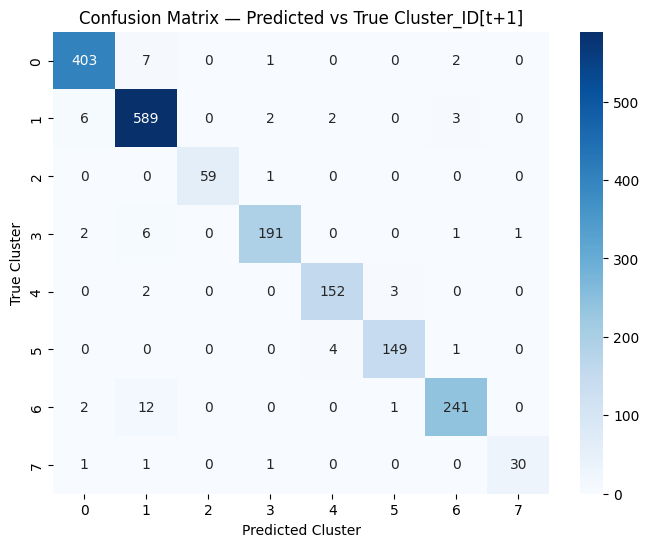

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.title("Confusion Matrix — Predicted vs True Cluster_ID[t+1]")
plt.show()

In [27]:

def print_per_cluster_accuracy(cm):
    """
    Print per-cluster accuracy from a given confusion matrix.

    Parameters:
        cm (np.ndarray): Square confusion matrix where rows = true labels, cols = predicted labels.
    """
    per_cluster_acc = cm.diagonal() / cm.sum(axis=1)
    print("\n🎯 Per-Cluster Accuracy:")
    for i, acc in enumerate(per_cluster_acc):
        print(f"  • Cluster {i}: Accuracy = {acc:.2%}")

In [28]:
precision, recall, f1, _ = precision_recall_fscore_support(
    true_clusters, predicted_clusters, average=None, zero_division=0
)
df_perf = pd.DataFrame(
    {
        "Cluster": list(range(len(precision))),
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
    }
)


In [29]:
def check_cluster_distribution(cluster_labels, window_size, val_pct=0.2):
    # Align cluster labels to match y[t] (since y starts after window_size)
    cluster_labels = cluster_labels[window_size:]
    total_len = len(cluster_labels)
    split_idx = int((1 - val_pct) * total_len)

    train_clusters = cluster_labels[:split_idx]
    val_clusters = cluster_labels[split_idx:]

    # Count unique clusters
    train_counts = Counter(train_clusters)
    val_counts = Counter(val_clusters)
    all_clusters = sorted(set(cluster_labels[~np.isnan(cluster_labels)]))

    print("📊 Per-Cluster Sample Counts:")
    df = pd.DataFrame(
        {
            "Cluster": all_clusters,
            "Train Count": [train_counts.get(c, 0) for c in all_clusters],
            "Val Count": [val_counts.get(c, 0) for c in all_clusters],
            "Total Count": [
                train_counts.get(c, 0) + val_counts.get(c, 0) for c in all_clusters
            ],
        }
    )

    print(df.to_string(index=False))

    # 🔔 Warn about missing clusters in training
    missing = [c for c in all_clusters if train_counts.get(c, 0) == 0]
    if missing:
        print(f"\n🚨 Warning: Clusters missing in training set: {missing}")
    else:
        print("\n✅ All clusters present in training set.")



In [ ]:
def summarize_training_run(config, cm, df_perf):
    """
    Print a full summary including config, per-cluster accuracy, and F1 breakdown.

    Args:
        config (dict): {
            "Model Type": ..., "Loss": ..., "Epochs": ..., etc.
        }
        cm (np.ndarray): Confusion matrix.
        df_perf (pd.DataFrame): Precision, Recall, F1 per cluster.
    """
    # Header
    print("⚙️ Training Summary:")
    for k, v in config.items():
        print(f"  {k}: {v}")

    print("\n🔍 Confusion matrix:")
    print(cm)

    # Accuracy
    print_per_cluster_accuracy(cm)

    # F1 summary
    print_summary_metrics(df_perf)

    check_cluster_distribution(cluster_labels, window_size=window_size, val_pct=validation_split)

### ⚙️ Training Summary

In [ ]:
# 🧮 Extract metrics from history
epochs_run = len(history.history["loss"])
final_train_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1] if USE_VALIDATION else None

# 🧠 Format labels
loss_name = loss_fn.__name__ if callable(loss_fn) else str(loss_fn)
callback_names = (
    [cb.__class__.__name__ for cb in callbacks] if "callbacks" in locals() else []
)
model_type = model.name if hasattr(model, "name") else "Unknown"
val_pct = f"{int(validation_split * 100)}%" if validation_split > 0 else "None"
predicted_pct = (
    f"{predicted_prob[0].max() * 100:.2f}%"
    if predicted_prob.size > 0
    else "N/A"
)
# Embedding Prediction Error
embedding_mse = np.mean(np.square(y - predicted_embeddings))

# 📦 Build config dict
config = {
    "Model Type": model_type,
    "Output Normalization": "Enabled" if USE_OUTPUT_NORMALIZATION else "Disabled",
    "Loss Function": loss_name,
    "Validation Split": val_pct,
    "Callbacks Used": ", ".join(callback_names) if callback_names else "None",
    "Epochs Run": epochs_run,
    "Final Train Loss": f"{final_train_loss:.6f}",
    "Embedding MSE": f"{embedding_mse:.6f}",
    "Predicted Probabilities": predicted_prob[0].tolist(),
    "Predicted Cluster": f"{predicted_cluster} / {predicted_pct}",
}
if final_val_loss is not None:
    config["Final Val Loss"] = f"{final_val_loss:.6f}"

# 📊 Final report
summarize_training_run(config, cm, df_perf)

⚙️ Training Summary:
  Model Type: stratum_hydra_forecaster
  Output Normalization: Enabled
  Loss Function: cosine_loss
  Validation Split: None
  Callbacks Used: ReduceLROnPlateau
  Epochs Run: 300
  Final Train Loss: 0.019791
  Embedding MSE: 0.000618
  Predicted Probabilities: [0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8]
  Predicted Cluster: 7.0 / 0.8000

🔍 Confusion matrix:
[[403   7   0   1   0   0   2   0]
 [  6 589   0   2   2   0   3   0]
 [  0   0  59   1   0   0   0   0]
 [  2   6   0 191   0   0   1   1]
 [  0   2   0   0 152   3   0   0]
 [  0   0   0   0   4 149   1   0]
 [  2  12   0   0   0   1 241   0]
 [  1   1   0   1   0   0   0  30]]

🎯 Per-Cluster Accuracy:
  • Cluster 0: Accuracy = 97.58%
  • Cluster 1: Accuracy = 97.84%
  • Cluster 2: Accuracy = 98.33%
  • Cluster 3: Accuracy = 95.02%
  • Cluster 4: Accuracy = 96.82%
  • Cluster 5: Accuracy = 96.75%
  • Cluster 6: Accuracy = 94.14%
  • Cluster 7: Accuracy = 90.91%

✅ Top 3 Clusters by F1 Score:
  • Cluster 2: F1 = 0